In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score
import json
import numpy as np

/home/bhavinkumar24212/anaconda3/envs/acad/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## BERT BiLSTM with Attention

Epoch 1/32 | Train Loss: 1.1195 | Val Loss: 1.1114 | Val Acc: 54.22%
Epoch 2/32 | Train Loss: 1.0301 | Val Loss: 1.0257 | Val Acc: 54.67%
Epoch 3/32 | Train Loss: 0.8937 | Val Loss: 0.9254 | Val Acc: 64.44%
Epoch 4/32 | Train Loss: 0.8391 | Val Loss: 0.9144 | Val Acc: 64.89%
Epoch 5/32 | Train Loss: 0.7861 | Val Loss: 0.9041 | Val Acc: 64.00%
Epoch 6/32 | Train Loss: 0.7697 | Val Loss: 0.8663 | Val Acc: 66.22%
Epoch 7/32 | Train Loss: 0.7253 | Val Loss: 0.8829 | Val Acc: 63.56%
Epoch 8/32 | Train Loss: 0.7124 | Val Loss: 0.8394 | Val Acc: 65.33%
Epoch 9/32 | Train Loss: 0.6733 | Val Loss: 0.8549 | Val Acc: 65.33%
Epoch 10/32 | Train Loss: 0.6511 | Val Loss: 0.8137 | Val Acc: 64.89%
Epoch 11/32 | Train Loss: 0.6257 | Val Loss: 0.8407 | Val Acc: 68.00%
Epoch 12/32 | Train Loss: 0.5884 | Val Loss: 0.9299 | Val Acc: 63.56%
Epoch 13/32 | Train Loss: 0.5525 | Val Loss: 0.8853 | Val Acc: 64.44%
Epoch 14/32 | Train Loss: 0.5438 | Val Loss: 0.8566 | Val Acc: 62.67%
Epoch 15/32 | Train Loss: 0.5

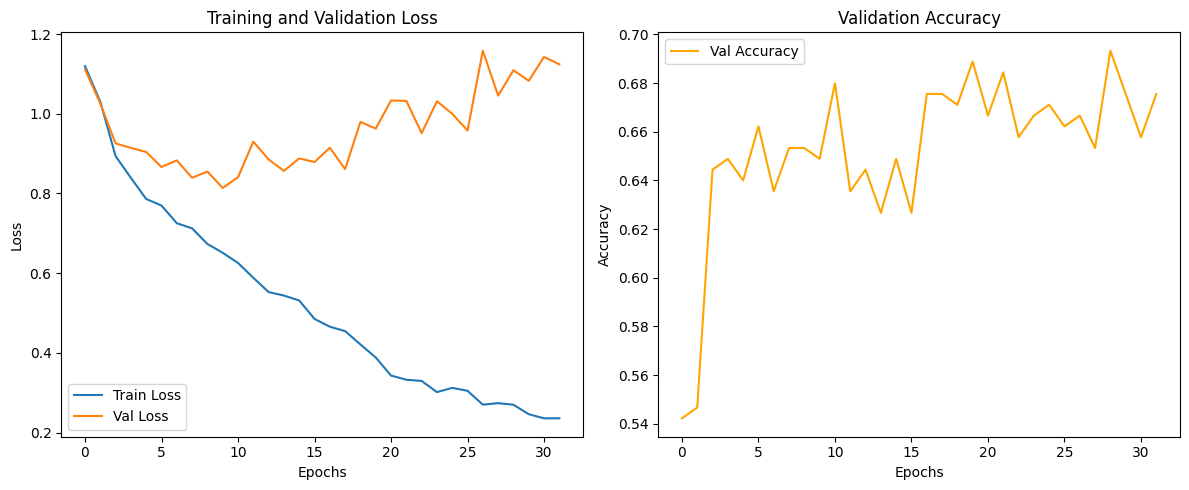

In [6]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

class ABSADataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        """Initializing dataset with tokenized data and polarity mapping"""
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.polarity_map = {'positive': 0, 'negative': 1, 'neutral': 2, 'conflict': 3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Fetching and processing a single data item"""
        item = self.data[idx]
        sentence = ' '.join(item['tokens'])
        aspect_term = item['aspect_term'][0]
        polarity = item['polarity']

        # Combining sentence and aspect term for BERT input
        text = f"{sentence} [SEP] {aspect_term}"

        # Tokenizing the combined text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Mapping polarity to a numerical label
        label = self.polarity_map[polarity]

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def load_data(file_path):
    """Loading JSON data from a file"""
    with open(file_path, 'r') as f:
        return json.load(f)

def preprocess_data(data):
    """Preprocessing raw data into a format suitable for training"""
    processed_data = []
    for example in data:
        sentence = example['sentence']
        tokens = sentence.split()
        for aspect in example['aspect_terms']:
            term = aspect['term']
            polarity = aspect['polarity']
            try:
                index = tokens.index(term)
            except ValueError:
                continue
            processed_data.append({
                'tokens': tokens,
                'polarity': polarity,
                'aspect_term': [term],
                'index': index
            })
    return processed_data

# Loading and preprocessing training and validation data
train_data = load_data('train.json')
val_data = load_data('val.json')
train_processed = preprocess_data(train_data)
val_processed = preprocess_data(val_data)

class LSTMAttention(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, n_layers, dropout):
        """Initializing the LSTM with attention mechanism"""
        super().__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(768, hidden_dim, n_layers, dropout=dropout, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        """Forward pass through the model"""
        # Extracting BERT embeddings
        with torch.no_grad():
            embedded = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # Passing embeddings through LSTM
        output, (hidden, cell) = self.lstm(embedded)

        # Applying attention mechanism
        attention_weights = torch.softmax(self.attention(output), dim=1)
        attended = (output * attention_weights).sum(dim=1)

        return self.fc(attended)

# Loading BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Setting hyperparameters
HIDDEN_DIM = 256
OUTPUT_DIM = 4  # 4 classes: positive, negative, neutral, conflict
N_LAYERS = 2
DROPOUT = 0.14427427037713858
LEARNING_RATE = 0.00132638227688203
BATCH_SIZE = 128
N_EPOCHS = 32

# Initializing the LSTM model
model = LSTMAttention(bert_model, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)

# Creating DataLoader for training and validation
train_dataset = ABSADataset(train_processed, tokenizer)
val_dataset = ABSADataset(val_processed, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Setting up device and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Lists to store training and validation metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(N_EPOCHS):
    model.train()
    epoch_train_loss = 0.0

    # Training phase
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * input_ids.size(0)
    
    # Calculating average training loss
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item() * input_ids.size(0)
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculating validation metrics
    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{N_EPOCHS} | '
          f'Train Loss: {avg_train_loss:.4f} | '
          f'Val Loss: {avg_val_loss:.4f} | '
          f'Val Acc: {val_accuracy*100:.2f}%')

# Plotting training and validation metrics
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Saving the trained model
torch.save(model.state_dict(), 'bert_bilstm_attention.pth')

def infer(model_path, tokenizer, test_data_path):
    """Running inference on test data"""
    # Loading the trained model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    # Loading and preprocessing test data
    test_data = load_data(test_data_path)
    test_processed = preprocess_data(test_data)
    test_dataset = ABSADataset(test_processed, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculating and printing test accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

### Inferencing Block

In [7]:
infer('bert_bilstm_attention.pth', tokenizer, 'val.json')

Test Accuracy: 67.56%


## Additonal Task (BERT, BART, ROBERTA)

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    BartTokenizer, BartForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    AdamW, get_linear_schedule_with_warmup
)
from sklearn.metrics import accuracy_score

### Dataset class for BERT, BART, ROBERTA

In [9]:
class ABSATransformerDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.polarity_map = {'positive': 0, 'negative': 1, 'neutral': 2, 'conflict': 3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        sentence = ' '.join(item['tokens'])
        aspect_term = item['aspect_term'][0]
        polarity = item['polarity']

        # Combine sentence and aspect term
        text = f"{sentence} [SEP] {aspect_term}"

        # Tokenize the input
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Convert polarity to a label
        label = self.polarity_map[polarity]

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

### BERT Fine-Tuning

In [ ]:

import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt


bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)


# Load datasets
train_dataset = ABSATransformerDataset(train_processed, bert_tokenizer)
val_dataset = ABSATransformerDataset(val_processed, bert_tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(5):  # 8 epochs total
    bert_model.train()
    epoch_train_loss = 0.0
    total_correct = 0
    total_examples = 0

    # Training phase
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Calculate accuracy
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct = (preds == labels).sum().item()
        total_correct += correct
        total_examples += labels.size(0)

        epoch_train_loss += loss.item()

    # Calculate epoch metrics
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = total_correct / total_examples
    train_accuracies.append(train_accuracy)

    # Validation phase
    bert_model.eval()
    epoch_val_loss = 0.0
    total_val_correct = 0
    total_val_examples = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            epoch_val_loss += loss.item()

            # Calculate validation accuracy
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct = (preds == labels).sum().item()
            total_val_correct += correct
            total_val_examples += labels.size(0)

    # Calculate validation metrics
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = total_val_correct / total_val_examples
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}')
    print(f'  Training Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy*100:.2f}%')
    print(f'  Validation Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy*100:.2f}%')
    print('-' * 60)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(range(1, 9), train_losses, label='Training Loss')
ax1.plot(range(1, 9), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Accuracy plot
ax2.plot(range(1, 9), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, 9), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

torch.save(bert_model.state_dict(), 'best_bert_model.pth')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
  Training Loss: 0.9377 | Accuracy: 64.98%
  Validation Loss: 0.7942 | Accuracy: 65.33%
------------------------------------------------------------
Epoch 2
  Training Loss: 0.6811 | Accuracy: 75.66%
  Validation Loss: 0.7192 | Accuracy: 68.89%
------------------------------------------------------------
Epoch 3
  Training Loss: 0.5352 | Accuracy: 81.61%
  Validation Loss: 0.6862 | Accuracy: 73.78%
------------------------------------------------------------


### BART Fine-Tuning

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BartTokenizer, BartForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Loading BART tokenizer and model
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
bart_model = BartForSequenceClassification.from_pretrained('facebook/bart-base', num_labels=4)

# Preparing datasets and data loaders
train_dataset = ABSATransformerDataset(train_processed, bart_tokenizer)
val_dataset = ABSATransformerDataset(val_processed, bart_tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Setting up device and moving model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bart_model.to(device)

# Configuring optimizer and learning rate scheduler
optimizer = AdamW(bart_model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Initializing lists to track training and validation metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop for 8 epochs
for epoch in range(5):
    # Training phase
    bart_model.train()
    epoch_train_loss = 0.0
    train_preds, train_labels = [], []
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass and loss calculation
        optimizer.zero_grad()
        outputs = bart_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Collecting predictions and labels for accuracy calculation
        epoch_train_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculating average training loss and accuracy
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_accuracy)

    # Validation phase
    bart_model.eval()
    epoch_val_loss = 0.0
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass for validation
            outputs = bart_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            epoch_val_loss += loss.item()

            # Collecting validation predictions and labels
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculating average validation loss and accuracy
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_accuracy)

    # Printing epoch results
    print(f'Epoch {epoch+1}/8')
    print(f'Train Loss: {avg_train_loss:.4f} | Acc: {train_accuracy*100:.2f}%')
    print(f'Val Loss: {avg_val_loss:.4f} | Acc: {val_accuracy*100:.2f}%')

# Plotting training and validation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting loss evolution
ax1.plot(range(1, 9), train_losses, label='Train')
ax1.plot(range(1, 9), val_losses, label='Val')
ax1.set_title('Loss Evolution')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting accuracy evolution
ax2.plot(range(1, 9), train_accuracies, label='Train')
ax2.plot(range(1, 9), val_accuracies, label='Val')
ax2.set_title('Accuracy Evolution')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

# Saving the trained model
torch.save(bart_model.state_dict(), 'best_bart_model.pth')

### ROBERTA Fine-Tuning

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Loading RoBERTa tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)

# Preparing datasets and data loaders
train_dataset = ABSATransformerDataset(train_processed, roberta_tokenizer)
val_dataset = ABSATransformerDataset(val_processed, roberta_tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Setting up device and moving model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
roberta_model.to(device)

# Configuring optimizer and learning rate scheduler
optimizer = AdamW(roberta_model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Initializing lists to track training and validation metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop for 8 epochs
for epoch in range(5):
    # Training phase
    roberta_model.train()
    epoch_train_loss = 0.0
    train_preds, train_labels = [], []
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass and loss calculation
        optimizer.zero_grad()
        outputs = roberta_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Collecting predictions and labels for accuracy calculation
        epoch_train_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculating average training loss and accuracy
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_accuracy)

    # Validation phase
    roberta_model.eval()
    epoch_val_loss = 0.0
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass for validation
            outputs = roberta_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            epoch_val_loss += loss.item()

            # Collecting validation predictions and labels
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculating average validation loss and accuracy
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_accuracy)

    # Printing epoch results
    print(f'Epoch {epoch+1}/8')
    print(f'Train Loss: {avg_train_loss:.4f} | Acc: {train_accuracy*100:.2f}%')
    print(f'Val Loss: {avg_val_loss:.4f} | Acc: {val_accuracy*100:.2f}%')

# Plotting training and validation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting loss evolution
ax1.plot(range(1, 9), train_losses, label='Train')
ax1.plot(range(1, 9), val_losses, label='Val')
ax1.set_title('Loss Evolution')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting accuracy evolution
ax2.plot(range(1, 9), train_accuracies, label='Train')
ax2.plot(range(1, 9), val_accuracies, label='Val')
ax2.set_title('Accuracy Evolution')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

# Saving the trained model
torch.save(roberta_model.state_dict(), 'best_roberta_model.pth')